In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from scipy import stats
from joblib import dump
from joblib import load
import xgboost as xgb
import matplotlib.pyplot as plt
from typing import Dict
from kaggle.api.kaggle_api_extended import KaggleApi
from dotenv import find_dotenv, load_dotenv
from collections import Counter
from src.data import make_dataset


In [2]:
load_dotenv(find_dotenv())
api = KaggleApi()
api.authenticate()

In [3]:
competition = os.environ['COMPETITION']

# Set up directories

In [4]:
project_dir = Path.cwd().parent
data_dir = project_dir / 'data'
raw_data_dir = data_dir / 'raw'
interim_data_dir = data_dir / 'interim'
processed_data_dir = data_dir / 'processed'
models_dir = project_dir / 'models'

# Load data

In [5]:
df_train = pd.read_csv(raw_data_dir / 'train.csv')
df_test = pd.read_csv(raw_data_dir / 'test.csv')
X_train = np.load(interim_data_dir / 'X_train.npy')
X_val = np.load(interim_data_dir / 'X_val.npy')
y_train = np.load(interim_data_dir / 'y_train.npy')
y_val = np.load(interim_data_dir / 'y_val.npy')
X_test = np.load(interim_data_dir / 'X_test.npy')
test_id = pd.read_csv(interim_data_dir / 'test_id.csv')

# Baseline

The base line prediction is simply to make them all negative.

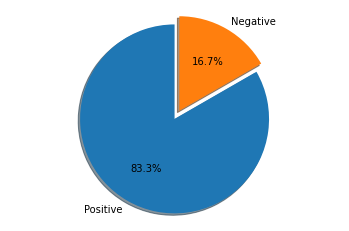

In [6]:
labels = 'Positive', 'Negative'
pos_count = (y_train == 1).sum()
neg_count = (y_train == 0).sum()
sizes = [pos_count, neg_count]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [7]:
pd.Series(y_train).value_counts(normalize=True)

1    0.833125
0    0.166875
dtype: float64

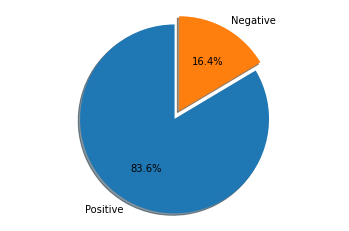

In [8]:
labels = 'Positive', 'Negative'
pos_count = (y_val == 1).sum()
neg_count = (y_val == 0).sum()
sizes = [pos_count, neg_count]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

## Baseline Score

The baseline score is to merely predict the larger class for all instances of the training set.

In [9]:
preds = [0] * len(y_val)
roc_auc_score(y_val, preds)

0.5

# Naive XGB

In [10]:
clf = xgb.XGBClassifier()

In [11]:
clf.fit(X_train, y_train)

c:\users\mactuary\.virtualenvs\assignment_1-rwa_wvyq\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:38:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [13]:
preds = clf.predict(X_val)
probs = clf.predict_proba(X_val)

In [14]:
auc = roc_auc_score(y_val, probs[:, 1])
auc

0.6601664813398136

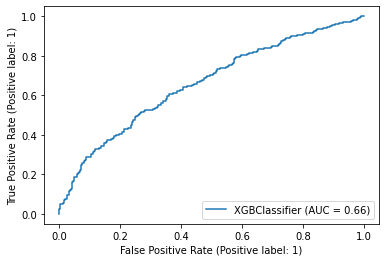

In [15]:
plot_roc_curve(clf, X_val, y_val)

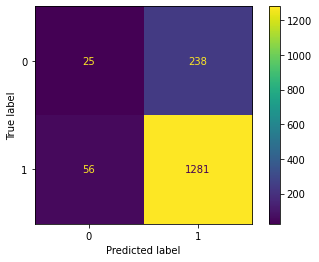

In [16]:
plot_confusion_matrix(clf, X_val, y_val)

In [17]:
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.31      0.10      0.15       263
           1       0.84      0.96      0.90      1337

    accuracy                           0.82      1600
   macro avg       0.58      0.53      0.52      1600
weighted avg       0.76      0.82      0.77      1600



# RandomizedSearchCV XGB

In [18]:
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA()),
        ('classifier', xgb.XGBClassifier(
            objective='binary:logistic',
            use_label_encoder=False,
            eval_metric='logloss'
        ))
])

param_dist = {
    'pca__n_components': stats.randint(1, X_train.shape[1]),
    'classifier__n_estimators': stats.randint(150, 1000),
    'classifier__learning_rate': stats.uniform(0.01, 0.6),
    'classifier__subsample': stats.uniform(0.3, 0.9),
    'classifier__max_depth': [3, 4, 5, 6, 7, 8, 9],
    'classifier__colsample_bytree': stats.uniform(0.5, 0.9),
    'classifier__min_child_weight': [1, 2, 3, 4]
}

cv = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    random_state=42,
    n_iter=100,
    cv=5,
    n_jobs=7,
    verbose=10,
    scoring='roc_auc'
)

cv.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\users\mactuary\.virtualenvs\assignment_1-rwa_wvyq\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.6030359         nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan 0.6053131
 0.57059935 0.63886461        nan        nan        nan        nan
        nan 0.61208138 0.57847498        nan 0.5770597  0.59930123
 0.61777557 0.65004205        nan        nan 0.62431806 0.6056311
 0.61637804 0.61323321 0.61663393        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.59355523        nan        nan        nan        nan        nan
        nan        nan 0.61312445        nan 0.59364145        nan
        nan 0.59824285        nan 0.59068581        nan 0.63659773
        nan        nan        nan        nan 0.59065112 0.67852174
 0.5768624         nan 0.61136259        nan        nan 0.61994339
        nan 0.64487181     

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('pca', PCA()),
                                             ('classifier',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            eval_metric='logloss',
                                                            gamma=None,
                                                            gpu_id=None,
                                                            importance_type='gain',
                                                            intera

In [19]:
dump(cv, models_dir / 'randomised_xgb.joblib')

['D:\\Projects\\assignment_1\\models\\randomised_xgb.joblib']

In [20]:
pd.DataFrame(cv.cv_results_).query('mean_test_score.notnull()').sort_values(by=['mean_test_score'], ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__colsample_bytree,param_classifier__learning_rate,param_classifier__max_depth,param_classifier__min_child_weight,param_classifier__n_estimators,param_classifier__subsample,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
65,3.654832,1.065492,0.007802,0.000749,0.5907,0.020933,5,2,184,0.602899,8,{'classifier__colsample_bytree': 0.59070020123...,0.659754,0.683118,0.694364,0.679096,0.676277,0.678522,0.011222,1
91,2.217798,0.173946,0.009306,0.000868,0.996429,0.108901,3,2,214,0.732333,15,{'classifier__colsample_bytree': 0.99642908528...,0.635862,0.676052,0.667828,0.650598,0.669995,0.660067,0.014764,2
25,3.447598,0.293985,0.012000,0.002607,0.651462,0.141259,3,4,262,0.358403,12,{'classifier__colsample_bytree': 0.65146193795...,0.601454,0.648213,0.671091,0.656823,0.672630,0.650042,0.025936,3
73,23.408809,7.104458,0.015001,0.002609,0.574956,0.065022,6,1,618,0.977137,16,{'classifier__colsample_bytree': 0.57495597007...,0.612665,0.674186,0.642072,0.643764,0.651672,0.644872,0.019758,4
93,10.666291,0.057357,0.012609,0.002263,0.557161,0.032093,9,1,554,0.350738,6,{'classifier__colsample_bytree': 0.55716064663...,0.624611,0.671005,0.643104,0.632099,0.632301,0.640624,0.016294,5
13,15.952193,0.094697,0.016802,0.002043,0.678844,0.013313,5,3,742,0.940208,3,{'classifier__colsample_bytree': 0.67884411338...,0.613717,0.656212,0.641658,0.638464,0.644272,0.638865,0.013932,6
59,27.735010,0.164399,0.022203,0.008680,0.582619,0.066494,8,2,602,0.726756,16,{'classifier__colsample_bytree': 0.58261915923...,0.607876,0.647223,0.639830,0.636481,0.651580,0.636598,0.015315,7
28,14.717075,0.760319,0.016596,0.006968,0.977841,0.27867,8,4,396,0.904922,11,{'classifier__colsample_bytree': 0.97784112498...,0.595952,0.626402,0.630981,0.628614,0.639641,0.624318,0.014877,8
71,13.261451,0.125439,0.013413,0.001477,0.850656,0.188581,5,1,761,0.309754,9,{'classifier__colsample_bytree': 0.85065627759...,0.583733,0.616535,0.637938,0.621888,0.639624,0.619943,0.020188,9
24,31.307832,3.121913,0.024904,0.006602,0.959673,0.260447,7,1,968,0.542471,15,{'classifier__colsample_bytree': 0.95967257231...,0.601762,0.632899,0.601596,0.615284,0.637338,0.617776,0.015072,10


In [21]:
pd.DataFrame(cv.cv_results_).query('mean_test_score.isnull()').sort_values(by=['mean_test_score'], ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__colsample_bytree,param_classifier__learning_rate,param_classifier__max_depth,param_classifier__min_child_weight,param_classifier__n_estimators,param_classifier__subsample,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.420186,0.439818,0.0,0.0,0.913324,0.210225,5,2,458,1.172919,12,{'classifier__colsample_bytree': 0.91332400276...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78
2,0.054797,0.010420,0.0,0.0,1.344697,0.010467,6,1,310,0.573818,12,{'classifier__colsample_bytree': 1.34469743811...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77
3,0.054000,0.005549,0.0,0.0,0.520756,0.324865,9,2,625,1.17638,15,{'classifier__colsample_bytree': 0.52075618253...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76
4,0.041400,0.004271,0.0,0.0,0.910463,0.481106,5,4,716,1.184908,3,{'classifier__colsample_bytree': 0.91046298579...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75
5,0.049798,0.002784,0.0,0.0,1.273946,0.418185,3,3,423,1.153997,14,{'classifier__colsample_bytree': 1.27394636606...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,0.021800,0.001940,0.0,0.0,1.35482,0.445432,9,1,599,0.374474,18,{'classifier__colsample_bytree': 1.35481992196...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52
92,0.037999,0.001898,0.0,0.0,0.635375,0.366478,9,1,976,1.057907,13,{'classifier__colsample_bytree': 0.63537520199...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60
94,0.035200,0.002563,0.0,0.0,1.122543,0.330608,7,2,920,0.799889,5,{'classifier__colsample_bytree': 1.12254295745...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53
95,0.035598,0.001020,0.0,0.0,1.153509,0.464249,5,1,234,0.70549,14,{'classifier__colsample_bytree': 1.15350875966...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49


In [22]:
pd.DataFrame(cv.cv_results_).query('mean_test_score.notnull()').sort_values(by=['mean_test_score'], ascending=False).iloc[0]

mean_fit_time                                                                  3.654832
std_fit_time                                                                   1.065492
mean_score_time                                                                0.007802
std_score_time                                                                 0.000749
param_classifier__colsample_bytree                                               0.5907
param_classifier__learning_rate                                                0.020933
param_classifier__max_depth                                                           5
param_classifier__min_child_weight                                                    2
param_classifier__n_estimators                                                      184
param_classifier__subsample                                                    0.602899
param_pca__n_components                                                               8
params                          

## Predictions with the best model

In [23]:
preds = cv.predict(X_val)
probs = cv.predict_proba(X_val)

In [24]:
roc_auc_score(y_val, probs[:, 1])

0.7007032940781672

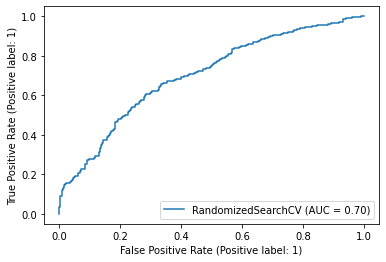

In [25]:
plot_roc_curve(cv, X_val, y_val)

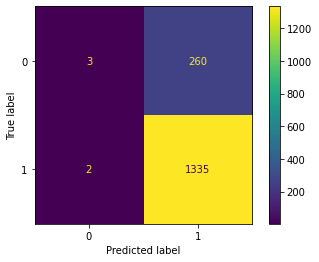

In [26]:
plot_confusion_matrix(cv, X_val, y_val)

In [27]:
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.60      0.01      0.02       263
           1       0.84      1.00      0.91      1337

    accuracy                           0.84      1600
   macro avg       0.72      0.50      0.47      1600
weighted avg       0.80      0.84      0.76      1600



The model is misclassifying the negative classes.

In [28]:
# fpr
260/(260+3)

0.9885931558935361

## Predict on test set

In [29]:
preds = cv.predict(X_test)
probs = cv.predict_proba(X_test)[:, 1]

## Save predictions

In [30]:
pred_name = 'TARGET_5Yrs'
pred_path = processed_data_dir / 'preds_randomised_xgb.csv'
make_dataset.save_predictions(probs, pred_name, test_id, pred_path)

In [31]:
pred_path.stem

'preds_randomised_xgb'

## Submit predictions